In [1]:
import pandas as pd
import requests

## Data collection

Se realiza la lectura de los objetos directamente desde el github de felipeares.

In [2]:
url = 'https://raw.githubusercontent.com/felipeares/legalbot-desafio-objetos/master/objetos.txt'
page = requests.get(url)
#Se identificó visualmente que el separador de los objetos corresponde a los caracteres \n\n
df_corpus = pd.DataFrame(page.text.split('\n\n'), columns = ['objeto'])

In [3]:
df_corpus.head()

,objeto
0,"CONSTRUCCIÓN, ALQUILER DE OTROS TIPOS DE MAQUI..."
1,el servicio de turismo por todo el territorio ...
2,SALON DE BELLEZA.
3,"CURSOS ONLINE DE MUSICA, COCINA, CLASES DE MUS..."
4,"el ejercicio de la actividad comercial,importa..."


## Data Preprocessing

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import string  #Se obtendrá los signos de puntuación
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer


In [6]:
#Método limpieza inicial y tokenización
def get_tokens_clean(objeto):
    #Se deja el texto en minúscula
    objeto = objeto.lower()
    
    #Elimina tildes
    a,b = 'áéíóúü','aeiouu',
    trans = str.maketrans(a,b)
    objeto = objeto.translate(trans)
    
    #Elimina caracteres que no sean palabras
    #En esta instancia se reemplazan los signos de puntuación por un espacio, ya que en algunos parragos
    # hay palabras con puntuaciones sin espacios. Ejemplo : producto,comercial.
    filtered_punctuation =  objeto.translate({ord(c): ' ' for c in string.punctuation}).replace('  ',' ')
    
    #tokeniza
    tokens = nltk.word_tokenize(filtered_punctuation)
    
    #Se eliminan stopwords (articulos, preposiciones, etc.)
    no_stopwords = [word for word in tokens if word not in stopwords.words('spanish')]
       
    return no_stopwords

#Función de derivacion 
def stem_words(tokens):
    stemmer_spanish = SnowballStemmer('spanish')
    stems = []
    for word in tokens:
        stem = stemmer_spanish.stem(word)
        stems.append(stem)
    return stems

#Elimina palabas menor a tres caracteres
def delete_characteres(tokens):
    return  [word for word in tokens if len(word)>3]

#Lematización de verbos. Por ahora sólo palabras en inglés.
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

#Se eliminan palabras derivadas con alta frecuencia, ya que sesga los grupos.
def replace_word_frequence(tokens):
    replace_word = []
    for word in tokens:
        word = word.replace('activ','').replace('servici','')
        if word == '': continue
        replace_word.append(word)
    return replace_word

In [7]:
from gensim.corpora import Dictionary

df_corpus['objeto_tokens'] = df_corpus['objeto'].map(get_tokens_clean)
df_corpus['objeto_tokens'] = df_corpus['objeto_tokens'].map(delete_characteres) 
df_corpus['objeto_stemm']  = df_corpus['objeto_tokens'].map(stem_words)
df_corpus['objeto_stemm']  = df_corpus['objeto_stemm'].map(replace_word_frequence)

## Data exploration

In [8]:
'''import matplotlib.pyplot as plt
flat_list = [word for idx,array_word in df_corpus.iterrows() for word in array_word['objeto_stemm']]
word_group = pd.DataFrame(flat_list,index=flat_list,columns=['word'])['word']
word_group_count = word_group.value_counts()
## VENTAS POR MES ####
plt.figure(figsize=(15, 15))
plt.ion()

plt.plot(word_group_count[word_group_count>300], 'b')  # Dibujamos una línea recta azul
plt.xlabel('palabras')  # Ponemos etiqueta al eje x
plt.ylabel(u'Cantidad')  # Ponemos etiqueta al eje y
plt.xticks(rotation=90)
plt.show()'''

"import matplotlib.pyplot as plt\nflat_list = [word for idx,array_word in df_corpus.iterrows() for word in array_word['objeto_stemm']]\nword_group = pd.DataFrame(flat_list,index=flat_list,columns=['word'])['word']\nword_group_count = word_group.value_counts()\n## VENTAS POR MES ####\nplt.figure(figsize=(15, 15))\nplt.ion()\n\nplt.plot(word_group_count[word_group_count>300], 'b')  # Dibujamos una línea recta azul\nplt.xlabel('palabras')  # Ponemos etiqueta al eje x\nplt.ylabel(u'Cantidad')  # Ponemos etiqueta al eje y\nplt.xticks(rotation=90)\nplt.show()"

Se genera un vector de la cantidad de veces que aparece cada palabra en el documento

In [9]:
flat_list = [word for tokens in df_corpus['objeto_stemm'].tolist() for word in tokens]
word_group = pd.DataFrame(flat_list,index=flat_list,columns=['word'])['word']
word_group_count = word_group.value_counts()
#word_group_count

vent                2214
tip                 1424
product             1368
tod                 1293
menor               1234
relacion            1192
construccion        1172
general             1096
cualqui             1064
clas                1036
bien                 917
propi                916
transport            838
compr                772
comercializacion     756
equip                749
empres               674
desarroll            665
mayor                661
obras                654
fabricacion          649
comerci              636
objet                631
importacion          628
realiz               621
articul              612
cuent                590
asesori              574
maquinari            568
distribucion         558
                    ... 
holajateri             1
compatibil             1
parachoqu              1
minidistribuidor       1
juni                   1
masofilaxi             1
prevension             1
peritaj                1
escenograf             1


Se eliminan palabras con alta frecuencia, ya que entrega poca importancia al momento de generar los tópicos.
Arbitrariamente, se elige el valor máximo de la frecuencia de la palabra (1000)

In [76]:
def delete_words_frequence(tokens):
    return [word for word in tokens if word not in word_group_count[word_group_count<10]]

In [77]:
df_corpus['no_frequence_words'] = df_corpus['objeto_stemm'].map(delete_words_frequence)

## Create dictionary

In [78]:
#Se crea diccionario
dct = Dictionary(df_corpus['no_frequence_words'].tolist())

## Bag of Words on the Data set

Representa el texto como una bolsa de palabras y su frecuencia de aparición, sin tener en cuenta gramática ni orden de palabras

In [79]:
from gensim import corpora, models

df_corpus['bow']   = df_corpus['no_frequence_words'].map(dct.doc2bow)
corpus_bow = df_corpus['bow'].tolist()

## TF-IDF

La columna tf_idf corresponde a un valor real lo cuál entrega como utilidad la importancia de una palabra en base en una colección de documentos, en este contexto corresponde a sólo un documento. Sus componente principales corresponden a TF(Frecuencia del término), donde básicamente genera la frecuencia de la palabra en su documento multiplicado por el IDF(Frecuencia del término inverso) trabaja mediante la cantidad de documentos que contiene la palabra que tiene como input, ésto dividido en la cantidad total de documentos de la colección, siendo ésta última división parámetro de entreda de la función de Logaritmo natural.

representa cómo de importante es una palabra en un documento dentro de un conjunto de documentos. El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra dentro del conjunto de documentos. De esta manera, se gestiona el hecho de que algunas palabras son más comunes que otras.

In [80]:
model_tfidf = models.TfidfModel(corpus_bow)
df_corpus['tf_idf'] = model_tfidf[df_corpus.bow.tolist()]
corpus_tfidf = df_corpus['tf_idf'].tolist()

## LDA 

extensión de pLSA, y a diferencia de la familia de modelos LSI, es un modelo generativo que representa los documentos como una mezcla de topics formados por palabras con una probabilidad (que se parece más a lo que es un documento real). Esto hace que LDA sea el método más común para extraer topics (topic modeling). Esto es, cada documento tendrá asociado n topics con una probabilidad. LDA descubre automáticamente estos topics, los cuales siguen una distribución Dirichlet. La parte de latente viene en este caso porque en estadística, una variable que hay que inferir en vez de observar se llama variable latente. En nuestro caso, observamos las palabras y no los temas, con lo que nuestras variables latentes son los temas.

#### Running LDA using Bag of Words

In [81]:
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

In [91]:
def run_lda_bow(topic_number):
    lda_model_path = "embedding/lda_model_bow"
    lda_model = models.LdaModel(corpus_bow, num_topics=topic_number, id2word=dct, passes=5, iterations=500)
    df_corpus['lda'] = lda_model[df_corpus.bow.tolist()]
    lda_model.save(lda_model_path)
    return lda_model    

#### Running LDA using TF-IDF

In [83]:
def run_lda_tfidf(topic_number):
    lda_model_path = "embedding/lda_model_tfidf"
    lda_model = models.LdaMulticore(corpus_tfidf, num_topics=topic_number, id2word=dct, passes=5, workers=4)
    #df_corpus['lda_tfidf'] = lda_model[df_corpus.tf_idf.tolist()]
    lda_model.save(lda_model_path)
    return lda_model    

## Optimization number of topics

In [90]:
def compute_coherence_values(dictionary, corpus, texts, start, limit):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit):
        model=models.LdaModel(corpus=corpus          #Corpus
                            , id2word=dictionary     #Diccionario
                            , num_topics=num_topics  #Número de tópicos
                            , passes=5               #Cuántas veces se supone que el algoritmo pasa sobre todo el corpus
                            , iterations=500         #Se establece un limite para la convergencia
                            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((num_topics,coherencemodel.get_coherence()))
        print('Numero de topicos : {}, valor coherencia : {}'.format(num_topics,coherencemodel.get_coherence()))
    return model_list, coherence_values

## Visualización

Mediante el package pyLDAvis, podemos visualizar los grupos que se han formado. Analizar sus tamaños, la distancia entre ellos o su solapamiento. En conjunto con la frecuencia de las palabras que pertenecen a cada grupo.

In [87]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()


def visualization_topics(model,corpus,name_html='test_topicos'):
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus, dct)
    pyLDAvis.save_html(LDAvis_prepared,name_html+str('.html'))
    #pyLDAvis.show(LDAvis_prepared)
    #pyLDAvis.display()

import matplotlib.pyplot as plt

def plt_topics_coherence(lista):
    x_val = [x[0] for x in lista]
    y_val = [x[1] for x in lista]
        
    plt.figure(figsize=(15, 15))
    plt.ion()
    plt.ylim(0,1)
    plt.plot(x_val,y_val)
    plt.plot(x_val,y_val,'or')
    plt.xlabel('Tópicos')  # Ponemos etiqueta al eje x
    plt.ylabel(u'Value coherence')  # Ponemos etiqueta al eje y
    plt.show()

## Call metodos LDA y optimización de k-tópicos

Ejecución de modelos con distintos numeros de tópicos. Éstos serán evaluados según su valor de coherencia.- TFIDF

Numero de topicos : 5, valor coherencia : 0.5004624703736953
Numero de topicos : 6, valor coherencia : 0.49560896660672754
Numero de topicos : 7, valor coherencia : 0.48572896381506003
Numero de topicos : 8, valor coherencia : 0.4873374912575926
Numero de topicos : 9, valor coherencia : 0.44471231652931364
Numero de topicos : 10, valor coherencia : 0.4579667196984613
Numero de topicos : 11, valor coherencia : 0.4355455509723221
Numero de topicos : 12, valor coherencia : 0.4957171498775374
Numero de topicos : 13, valor coherencia : 0.4840660210839065
Numero de topicos : 14, valor coherencia : 0.46959106560568475


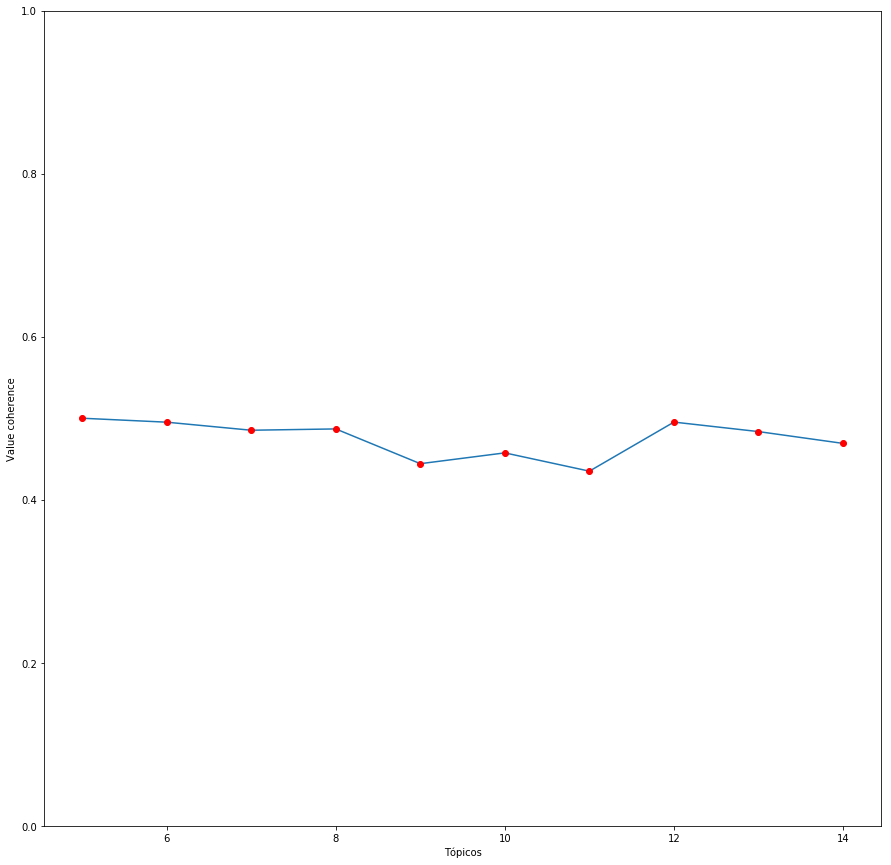

In [88]:
models_tfidf, list_topics_coherence_tfidf = compute_coherence_values(dct,corpus_tfidf,df_corpus['no_frequence_words'],5,15)
plt_topics_coherence(list_topics_coherence_tfidf)

Mediante la respuesta del gráfico anterior, podemos discriminar y elegir el número K conveniente para ejecutar.

In [89]:
number_topics = 12 
lda_model_tfidf    =  run_lda_tfidf(number_topics)
visualization_topics(lda_model_tfidf,corpus_tfidf,'topics_tfidf')

c:\users\jota\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Ejecución de modelos con distintos numeros de tópicos. Éstos serán evaluados según su valor de coherencia.- BOW

Numero de topicos : 5, valor coherencia : 0.5158045028283267
Numero de topicos : 6, valor coherencia : 0.5532939910543321
Numero de topicos : 7, valor coherencia : 0.507857636833768
Numero de topicos : 8, valor coherencia : 0.5377393962490642
Numero de topicos : 9, valor coherencia : 0.5472713441008765
Numero de topicos : 10, valor coherencia : 0.5657921619169424
Numero de topicos : 11, valor coherencia : 0.5815493381762926
Numero de topicos : 12, valor coherencia : 0.5651518098109269
Numero de topicos : 13, valor coherencia : 0.5505207929458076
Numero de topicos : 14, valor coherencia : 0.5364067373542439


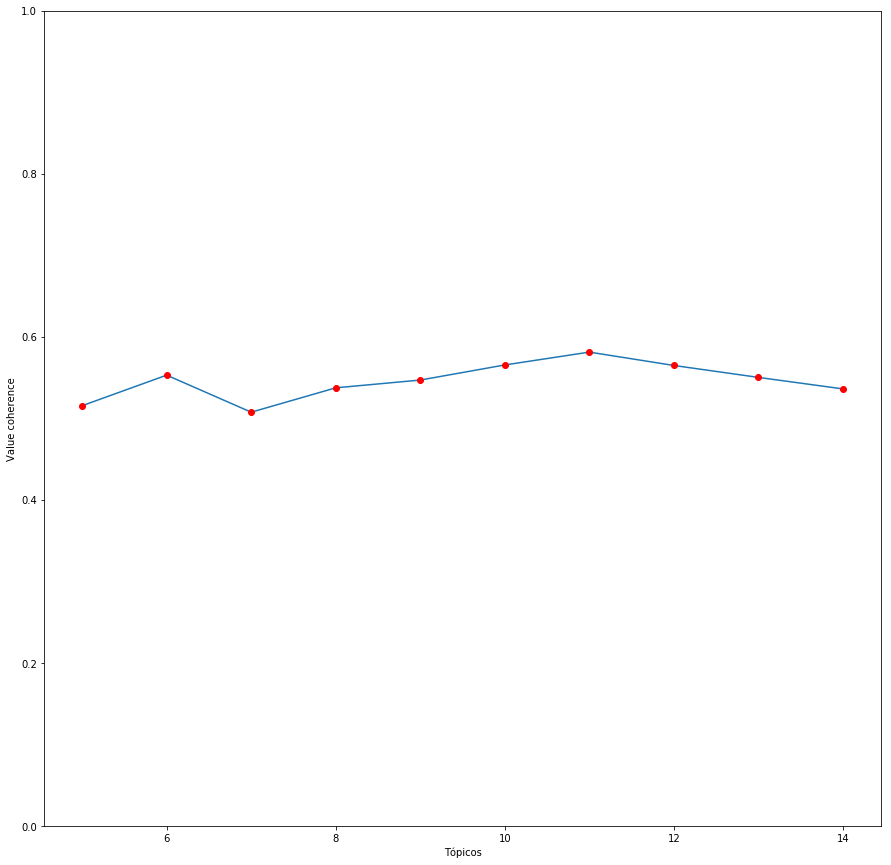

In [93]:
models_bow, list_topics_coherence_bow = compute_coherence_values(dct,corpus_bow,df_corpus['no_frequence_words'],5,15)
plt_topics_coherence(list_topics_coherence_bow)

In [94]:
number_topics = 11
lda_model_bow    =  run_lda_bow(number_topics)
visualization_topics(lda_model_bow,corpus_bow,'topics_bow')

c:\users\jota\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Anexos

Conceptos : https://labs.beeva.com/conceptos-en-la-extracci%C3%B3n-autom%C3%A1tica-de-informaci%C3%B3n-de-documentos-c6dfcf6ba36a